In [2]:
# Plotting related
import os
import sys

sys.tracebacklimit = 0
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio


# Scikit-learn related imports
import numpy as np
import pandas as pd

pd.set_option("display.float_format", "{:.2f}".format)
pd.set_option("display.max_colwidth", None)
pd.options.mode.copy_on_write = True

import importlib

# Constants and functions for this project
import constants
from constants import *
import auxFunctions as af

import shutil
shutil.copy('constants.py', 'export/')
from IPython.display import display, HTML, Markdown

# Change the current working directory
os.chdir("/home/yonatan/Documents/projects/vaccines/code")

sys.tracebacklimit = 0
def exception_handler(exception_type, exception, traceback):
    # All your trace are belong to us!
    # your format
    print(f"{exception_type.__name__}, {exception}")

sys.excepthook = exception_handler

In [3]:
# Reset index to insure we iterate over them in the order of max_diff
basedir = "/home/yonatan/Documents/projects/vaccines/code"
pkl_path = os.path.join(basedir, f"pickles/results-max-diff{ROC_PRC_str}.pkl")
results = pd.read_pickle(pkl_path).reset_index()

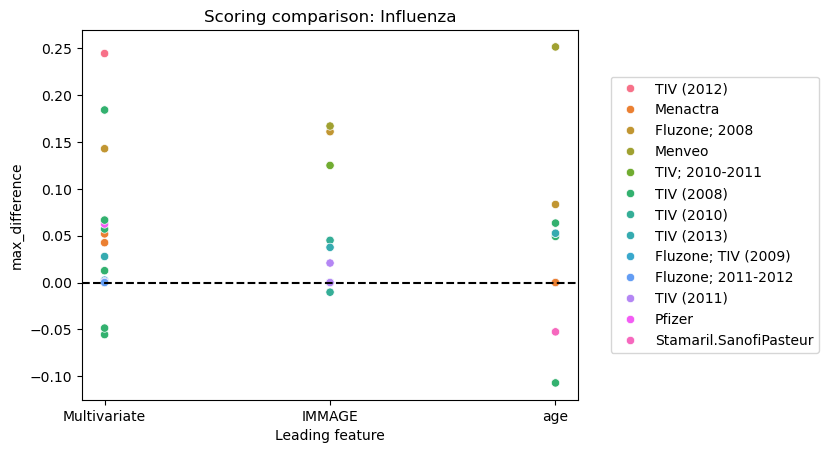

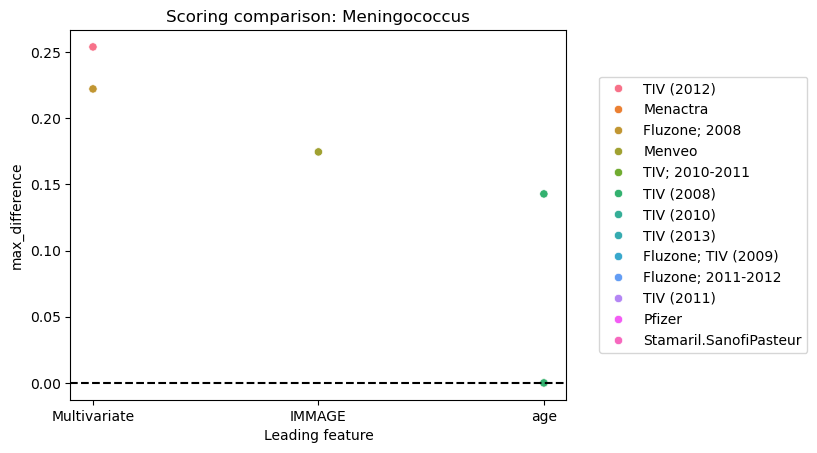

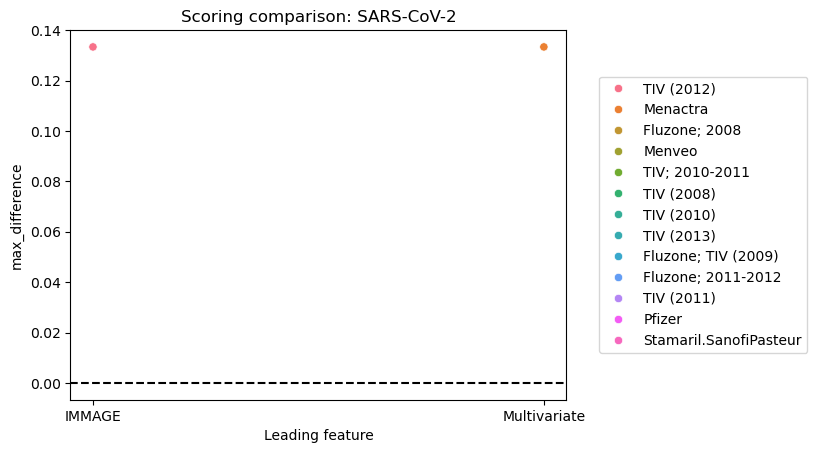

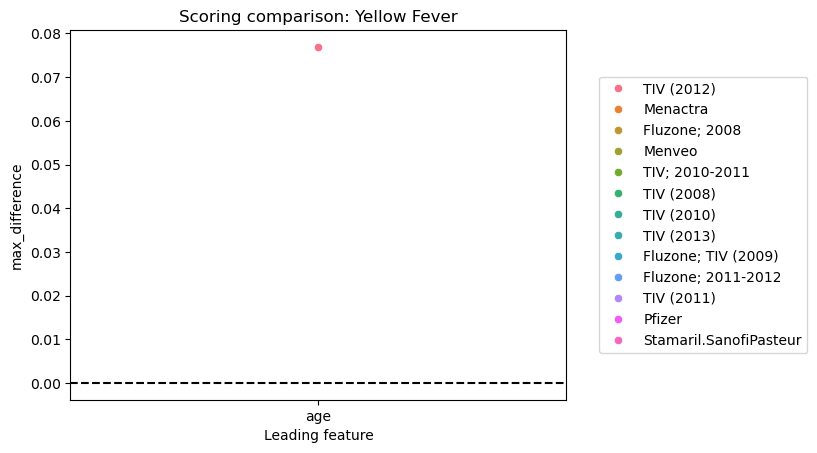

In [5]:
# Plot each virus separately, comparing IMMAGE, multivar and age
importlib.reload(af)
importlib.reload(constants)

# Plot by whether IMMAGE or combined IMMAGE & Age was better
results_filtered = results[(results['Dataset'] != 'GSE52245.SDY1260') | (results['Strain'] == 'IgM_serotype_A') | (results['Strain'] == 'IgM_serotype_C')]
results_filtered[results_filtered["Virus"].str.contains("Men", case=False)]
results = results_filtered
palette = {"age": "orange", "IMMAGE": "blue", "Multivariate": "green"}
results['immage_contrib'] = results["Composite", "IMMAGE"] - results["Composite", "Age"]
results['multivar_contrib'] = results["Composite", "Multivariate"] - results["Composite", "Age"]

# For each row (=dataset,strain combination) add the mean score of the group(=virus) it belongs to
grouped_data = results.groupby("Virus")['immage_contrib'].mean().reset_index()
grouped_data.columns = ["Virus", 'mean_immage_contrib']
sorted_data = pd.merge(results, grouped_data, on="Virus", how='left')

# sorted_grouped_data = grouped_data.apply(lambda g: g.sort_values("max_difference", ignore_index=True, ascending=False).reset_index(drop=True)
# )
sorted_data = sorted_data.sort_values("immage_contrib", ignore_index=True, ascending=False).reset_index(drop=True)
sorted_data.drop('index', axis=1, inplace=True)
def get_leading_feature(row):
    immage_age = row["Composite", "IMMAGE"] - row["Composite", "Age"]
    multivar_age = row["Composite", "Multivariate"] - row["Composite", "Age"]
    if max(immage_age, multivar_age) > 0:
        if immage_age > multivar_age:
            feature = "IMMAGE"
        else :
            feature = "Multivariate"
    else:
        feature = "age"
    return feature

sorted_data["Leading feature"] = results.apply(lambda row: get_leading_feature(row), axis=1)


for virus in sorted_data.Virus.unique():
    data = sorted_data[sorted_data["Virus"] == virus].reset_index()
    scatter = sns.scatterplot(x=data["Leading feature"], y=data["max_difference"], hue=sorted_data[vaccine_col])
    # scatter = sns.scatterplot(x=np.ones(data["immage_contrib"].shape[0])*1, y=data["immage_contrib"], hue=data[vaccine_col])
    # scatter = sns.scatterplot(x=np.ones(data["multivar_contrib"].shape[0])*2, y=data["multivar_contrib"], hue=sorted_data[vaccine_col])
    plt.xticks(rotation=0) 

    # plt.xticks(range(len(sorted_data)), sorted_data[vaccine_col], rotation=45)  # Adjust the rotation angle as needed
    handles, labels = scatter.get_legend_handles_labels()
    plt.legend(handles, labels, loc="center right", bbox_to_anchor=(1.5, 0.5))

    plt.axhline(y=0, color="black", linestyle="--")
    plt.title(f"Scoring comparison: {virus}")
    plt.show()